In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [128]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
from mutual_info_reg_utils import MLPClassifierMutualInfoReg, get_trainloader_with_vuln, get_trainloader_with_nonvuln, split_datasets, EnsembleMLPClassifier
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [4]:
i=-0.4
experiments = {}
for mp in [0.2, 0.3, 0.4, 0.5, 1]:
    experiment = MIAExperiment(sampling_condition_dict = 
        {
                'correlation': -0.4,
                'subgroup_col_name': 'SEX',
                'marginal_prior': mp,
                'n': 50000,
                'corr_btn_sens_and_output_per_subgroup': (i, i),
                # 'fixed_corr_in_test_data': True
        }, shortname = f"Corr_btn_sens_and_output_({mp}))"
    )
    experiments[f"{mp}"] = experiment

[0, 1]
{0: {(0, 1): 3946, (0, 0): 219, (1, 1): 8554, (1, 0): 12281}, 1: {(0, 1): 3946, (0, 0): 219, (1, 1): 8554, (1, 0): 12281}}


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


{0: {(0, 1): 3946, (0, 0): 219, (1, 1): 8554, (1, 0): 12281}, 1: {(0, 1): 3946, (0, 0): 219, (1, 1): 8554, (1, 0): 12281}}


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


[0, 1]
{0: {(0, 1): 4991, (0, 0): 777, (1, 1): 7509, (1, 0): 11723}, 1: {(0, 1): 4991, (0, 0): 777, (1, 1): 7509, (1, 0): 11723}}


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


{0: {(0, 1): 4991, (0, 0): 777, (1, 1): 7509, (1, 0): 11723}, 1: {(0, 1): 4991, (0, 0): 777, (1, 1): 7509, (1, 0): 11723}}


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


[0, 1]
{0: {(0, 1): 5830, (0, 0): 1312, (1, 1): 6670, (1, 0): 11188}, 1: {(0, 1): 5830, (0, 0): 1312, (1, 1): 6670, (1, 0): 11188}}


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


{0: {(0, 1): 5830, (0, 0): 1312, (1, 1): 6670, (1, 0): 11188}, 1: {(0, 1): 5830, (0, 0): 1312, (1, 1): 6670, (1, 0): 11188}}


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


[0, 1]
{0: {(0, 1): 6523, (0, 0): 1809, (1, 1): 5977, (1, 0): 10691}, 1: {(0, 1): 6523, (0, 0): 1809, (1, 1): 5977, (1, 0): 10691}}


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


{0: {(0, 1): 6523, (0, 0): 1809, (1, 1): 5977, (1, 0): 10691}, 1: {(0, 1): 6523, (0, 0): 1809, (1, 1): 5977, (1, 0): 10691}}


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


[0, 1]
{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


In [5]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.original_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1]
    experiment.original_df = experiment.original_df.drop(['is_train'], axis=1).copy().reset_index(drop=True)
    experiment.aux_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1]
    experiment.aux_df = experiment.aux_df.drop(['is_train'], axis=1)
    experiment.y_column = experiment.ds.ds.meta['y_column']

In [69]:
experiments['0.2'].original_df[['PINCP']].value_counts()

PINCP
0        25000
1        25000
Name: count, dtype: int64

In [9]:
save_model = True
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Loaded classifier for experiment from file: Census19_correlation_-0.4_subgroup_col_name_SEX_marginal_prior_0.2_n_50000_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN


In [10]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.sens_pred, _ = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    experiment.sens_ground_truth = experiment.X_train[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel()
    experiment.correct_indices = (experiment.sens_pred == experiment.X_train[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
    experiment.incorrect_indices = ~experiment.correct_indices
    experiment.correct_indices_LOMIA = (experiment.sens_pred_LOMIA == experiment.X_train[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
    experiment.incorrect_indices_LOMIA = ~experiment.correct_indices_LOMIA


In [11]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    try:
        experiment.all_vuln_scores = np.load(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores.npy')
    except:
        # experiment.ds.ds.filenameroot = f'Census19_correlation_-0.4_subgroup_col_name_SEX_marginal_prior_{experiment_key}_n_50000_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN'
        print(experiment.ds.ds.filenameroot)
        experiment.all_vuln_scores = np.array([get_vulnerability_score(experiment, experiment.X_train, experiment.y_tr, experiment.original_df, index, k=5) for index in tqdm(experiment.X_train.index)])
        np.save(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_vuln_scores.npy', experiment.all_vuln_scores)

In [12]:
from collections import Counter
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.mp = np.array([Counter(experiment.sens_ground_truth)[i] for i in [0, 1]])[experiment.sens_ground_truth.astype(int)]/experiment.X_test.shape[0]
    # print(Counter(experiment.correct_indices_LOMIA))
    # print(experiment.all_vuln_scores)
    # print(experiment.mp)
    experiment.all_vuln_scores_rounded = (experiment.all_vuln_scores > experiment.mp).astype(int)

<Axes: >

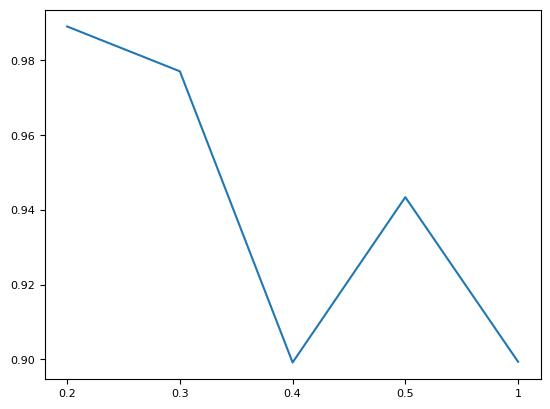

In [18]:
mps = []
accuracies_CSMIA = []
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    mps.append(experiment_key)
    accuracies_CSMIA.append(accuracy_score(experiment.correct_indices, experiment.all_vuln_scores_rounded))
    # accuracies_CSMIA.append(recall_score(experiment.correct_indices, experiment.all_vuln_scores_rounded))

sns.lineplot(x=mps, y=accuracies_CSMIA)

<Axes: >

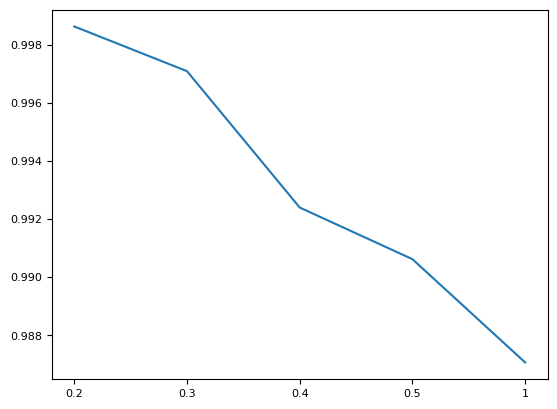

In [14]:
mps = []
accuracies_LOMIA = []
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    mps.append(experiment_key)
    accuracies_LOMIA.append(accuracy_score(experiment.correct_indices_LOMIA, experiment.all_vuln_scores_rounded))

sns.lineplot(x=mps, y=accuracies_LOMIA)

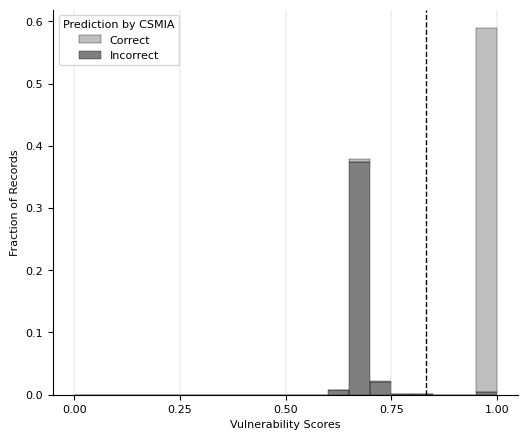

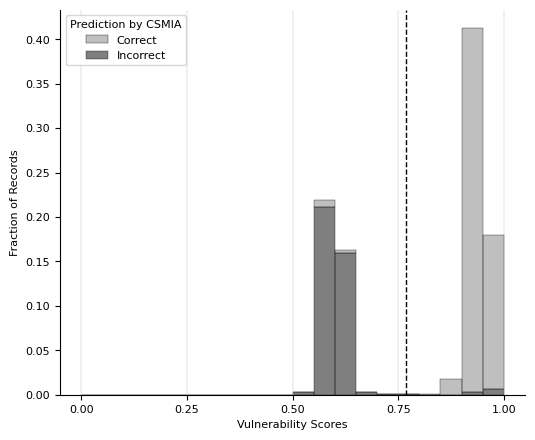

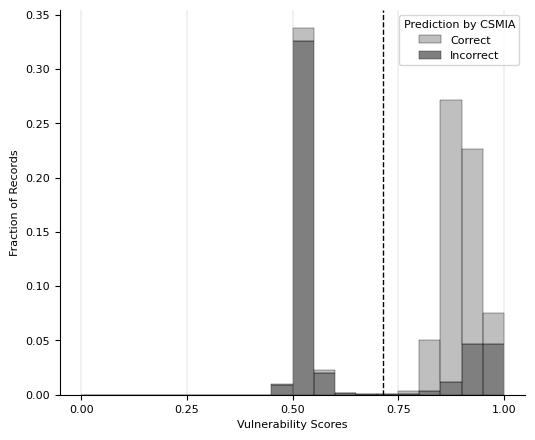

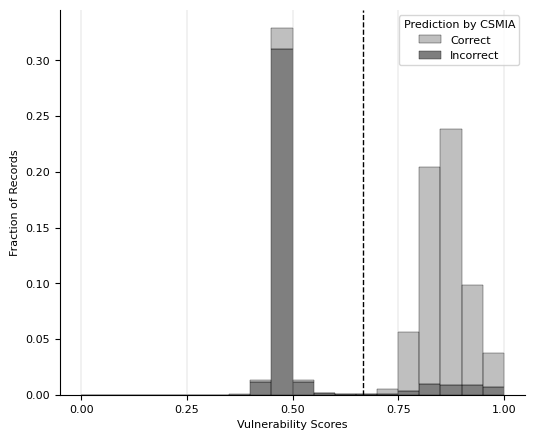

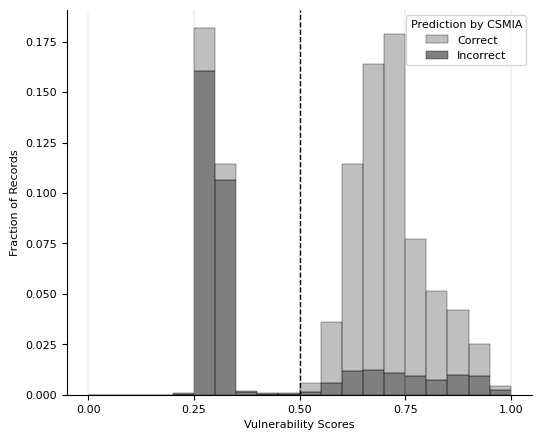

In [141]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    married_indices = experiment.X_train[experiment.X_train[f'{experiment.ds.ds.meta["sensitive_column"]}_1']==1].index
    draw_hist_plot(experiment.all_vuln_scores[married_indices], experiment.correct_indices[married_indices], experiment.incorrect_indices[married_indices], vuln_threshold=1/(1+float(experiment_key)))

In [20]:
experiments.keys()

dict_keys(['0.2', '0.3', '0.4', '0.5', '1'])

In [75]:
betas = [0.01, 0.05, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3]

model_zero_by_beta = {}

experiment = experiments['0.2']
train_loader = get_trainloader_with_vuln(experiment.X_train, experiment.y_tr_onehot, experiment.all_vuln_scores_rounded)

for beta in betas:
    try:
        model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        model.load_state_dict(torch.load(f"{experiment.ds.ds.filenameroot}_mutual_info_reg_{beta}.pt"))
    except:
        model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        model.train_mir(train_loader, beta=beta)
        torch.save(model.state_dict(), f"{experiment.ds.ds.filenameroot}_mutual_info_reg_{beta}.pt")
    
    model_zero_by_beta[beta] = model


In [76]:
betas = [0.01, 0.05, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]

model_by_beta = {}

experiment = experiments['0.2']
train_loader = get_trainloader_with_vuln(experiment.X_train, experiment.y_tr_onehot, experiment.all_vuln_scores_rounded)

for beta in betas:
    try:
        model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        model.load_state_dict(torch.load(f"{experiment.ds.ds.filenameroot}_mutual_info_reg_vuln_{beta}.pt"))
    except:
        model = MLPClassifierMutualInfoReg(n_in_features=experiment.X_train.shape[1], n_feat_dim=10, n_out_features=experiment.y_tr_onehot.shape[1]).to('mps')
        model.train_mir(train_loader, beta=beta, selective_reg=True)
        torch.save(model.state_dict(), f"{experiment.ds.ds.filenameroot}_mutual_info_reg_vuln_{beta}.pt")
    
    model_by_beta[beta] = model


In [116]:
experiment = experiments['0.2']
train_loader = get_trainloader_with_nonvuln(experiment.X_train, experiment.y_tr_onehot, experiment.all_vuln_scores_rounded)

model = model_by_beta[0.3]
finetuned_model = copy.deepcopy(model)
finetuned_model.train_mir(train_loader, beta=0, selective_reg=False, epochs=1)

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


In [121]:
for mdl in [model, finetuned_model]:
    test_acc = mdl.test_mir(experiment.X_test, experiment.y_te_onehot)
    sens_pred_CSMIA, case_indices = CSMIA_attack(mdl, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    # sens_pred_LOMIA = LOMIA_attack(experiment, mdl, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    csmia_acc = score(experiment.sens_ground_truth, sens_pred_CSMIA, metric=metric)
    # lomia_acc = score(experiment.sens_ground_truth, sens_pred_LOMIA, metric=metric)
    temp_dict = {
        'test_acc': test_acc,
        'csmia_acc': csmia_acc,
        # 'lomia_acc': lomia_acc,
        # 'beta': beta,
        # 'type': 'regular'
    }
    print(case_indices[1].sum())
    print(temp_dict)

24082
{'test_acc': 0.5603, 'csmia_acc': 0.5054021608643458}
0
{'test_acc': 0.8334, 'csmia_acc': 0.10336134453781512}


In [124]:
experiment = experiments['1']
train_loader = get_trainloader_with_nonvuln(experiment.X_train, experiment.y_tr_onehot, experiment.all_vuln_scores_rounded)

model = model_by_beta[0.3]
finetuned_model = copy.deepcopy(model)
finetuned_model.train_mir(train_loader, beta=0, selective_reg=False, epochs=10)

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


In [125]:
for mdl in [model, finetuned_model]:
    test_acc = mdl.test_mir(experiment.X_test, experiment.y_te_onehot)
    sens_pred_CSMIA, case_indices = CSMIA_attack(mdl, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    # sens_pred_LOMIA = LOMIA_attack(experiment, mdl, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    csmia_acc = score(experiment.sens_ground_truth, sens_pred_CSMIA, metric=metric)
    # lomia_acc = score(experiment.sens_ground_truth, sens_pred_LOMIA, metric=metric)
    temp_dict = {
        'test_acc': test_acc,
        'csmia_acc': csmia_acc,
        # 'lomia_acc': lomia_acc,
        # 'beta': beta,
        # 'type': 'regular'
    }
    print(case_indices[1].sum())
    print(temp_dict)

24095
{'test_acc': 0.49854, 'csmia_acc': 0.49628}
49919
{'test_acc': 0.30014, 'csmia_acc': 0.3}


In [165]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    splits = split_datasets(experiment.X_train, experiment.y_tr_onehot, experiment.all_vuln_scores_rounded)
    # model = model_by_beta[0.01]
    ensemble_model = EnsembleMLPClassifier()
    # ensemble_model.f
    ensemble_model.fit(splits[0], splits[1])
    experiment.ensemble_model = ensemble_model

100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


In [176]:
perf_dict = {}

def score(x, y, metric='accuracy'):
    if metric == 'accuracy':
        return accuracy_score(x, y)
    elif metric == 'precision':
        return precision_score(x, y, pos_label=0)
    elif metric == 'recall':
        return recall_score(x, y, pos_label=0)

metric='accuracy'

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    perf_dict[experiment_key] = {}
    models = [experiment.clf, experiment.ensemble_model]
    for i, model in enumerate(models):
        test_acc = model.score(experiment.X_test, experiment.y_te_onehot)
        sens_pred_CSMIA, _ = CSMIA_attack(model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
        sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
        csmia_acc = score(experiment.sens_ground_truth, sens_pred_CSMIA, metric=metric)
        lomia_acc = score(experiment.sens_ground_truth, sens_pred_LOMIA, metric=metric)
        perf_dict[experiment_key][['Vanilla', 'Ensemble'][i]] = {
            'test_acc': test_acc,
            'csmia_acc': csmia_acc,
            'lomia_acc': lomia_acc
        }

In [177]:
perf_dict

{'0.2': {'Vanilla': {'test_acc': 0.87222,
   'csmia_acc': 0.64874,
   'lomia_acc': 0.65012},
  'Ensemble': {'test_acc': 0.89358,
   'csmia_acc': 0.6468,
   'lomia_acc': 0.64908}},
 '0.3': {'Vanilla': {'test_acc': 0.84574,
   'csmia_acc': 0.66902,
   'lomia_acc': 0.6703},
  'Ensemble': {'test_acc': 0.85444,
   'csmia_acc': 0.63726,
   'lomia_acc': 0.61766}},
 '0.4': {'Vanilla': {'test_acc': 0.82676,
   'csmia_acc': 0.6168,
   'lomia_acc': 0.68286},
  'Ensemble': {'test_acc': 0.82454,
   'csmia_acc': 0.55998,
   'lomia_acc': 0.50464}},
 '0.5': {'Vanilla': {'test_acc': 0.81736,
   'csmia_acc': 0.67752,
   'lomia_acc': 0.68964},
  'Ensemble': {'test_acc': 0.80662,
   'csmia_acc': 0.49986,
   'lomia_acc': 0.41878}},
 '1': {'Vanilla': {'test_acc': 0.7854,
   'csmia_acc': 0.68046,
   'lomia_acc': 0.7001},
  'Ensemble': {'test_acc': 0.77638, 'csmia_acc': 0.426, 'lomia_acc': 0.31816}}}

In [178]:
perf_dict = {}

def score(x, y, metric='accuracy'):
    if metric == 'accuracy':
        return accuracy_score(x, y)
    elif metric == 'precision':
        return precision_score(x, y, pos_label=0)
    elif metric == 'recall':
        return recall_score(x, y, pos_label=0)

metric='recall'

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    perf_dict[experiment_key] = {}
    models = [experiment.clf, experiment.ensemble_model]
    for i, model in enumerate(models):
        test_acc = model.score(experiment.X_test, experiment.y_te_onehot)
        sens_pred_CSMIA, _ = CSMIA_attack(model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
        sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
        csmia_acc = score(experiment.sens_ground_truth, sens_pred_CSMIA, metric=metric)
        lomia_acc = score(experiment.sens_ground_truth, sens_pred_LOMIA, metric=metric)
        perf_dict[experiment_key][['Vanilla', 'Ensemble'][i]] = {
            'test_acc': test_acc,
            'csmia_acc': csmia_acc,
            'lomia_acc': lomia_acc
        }

In [179]:
perf_dict

{'0.2': {'Vanilla': {'test_acc': 0.87222,
   'csmia_acc': 0.9399759903961584,
   'lomia_acc': 0.9466986794717888},
  'Ensemble': {'test_acc': 0.89358,
   'csmia_acc': 0.9474189675870348,
   'lomia_acc': 0.9474189675870348}},
 '0.3': {'Vanilla': {'test_acc': 0.84574,
   'csmia_acc': 0.8554091539528432,
   'lomia_acc': 0.8632108183079057},
  'Ensemble': {'test_acc': 0.85444,
   'csmia_acc': 0.8130201109570042,
   'lomia_acc': 0.8487343966712899}},
 '0.4': {'Vanilla': {'test_acc': 0.82676,
   'csmia_acc': 0.8239288714645757,
   'lomia_acc': 0.8104872584710165},
  'Ensemble': {'test_acc': 0.82454,
   'csmia_acc': 0.623284794175301,
   'lomia_acc': 0.6668300196023523}},
 '0.5': {'Vanilla': {'test_acc': 0.81736,
   'csmia_acc': 0.7800648103696591,
   'lomia_acc': 0.774903984637542},
  'Ensemble': {'test_acc': 0.80662,
   'csmia_acc': 0.4353696591454633,
   'lomia_acc': 0.48865818530964955}},
 '1': {'Vanilla': {'test_acc': 0.7854,
   'csmia_acc': 0.71008,
   'lomia_acc': 0.70288},
  'Ensemble

In [150]:
ensemble_model.score(experiment.X_test, experiment.y_te)

0.77638

In [151]:
sens_pred_CSMIA, _ = CSMIA_attack(ensemble_model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
# sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
csmia_acc = score(experiment.sens_ground_truth, sens_pred_CSMIA, metric=metric)
csmia_acc

In [153]:
experiment = experiments['0.2']
splits = split_datasets(experiment.X_train, experiment.y_tr_onehot, experiment.all_vuln_scores_rounded)
# model = model_by_beta[0.01]
ensemble_model = EnsembleMLPClassifier()
# ensemble_model.f
ensemble_model.fit(splits[0], splits[1])

100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


In [154]:
ensemble_model.score(experiment.X_test, experiment.y_te)

0.89358

In [155]:
sens_pred_CSMIA, _ = CSMIA_attack(ensemble_model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
# sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
csmia_acc = score(experiment.sens_ground_truth, sens_pred_CSMIA, metric=metric)
csmia_acc

0.9474189675870348

In [96]:
perf_dict = {}

def score(x, y, metric='accuracy'):
    if metric == 'accuracy':
        return accuracy_score(x, y)
    elif metric == 'precision':
        return precision_score(x, y, pos_label=0)
    elif metric == 'recall':
        return recall_score(x, y, pos_label=0)

metric='recall'

for beta in model_zero_by_beta:
    model = model_zero_by_beta[beta]
    test_acc = model.test_mir(experiment.X_test, experiment.y_te_onehot)
    sens_pred_CSMIA, _ = CSMIA_attack(model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    csmia_acc = score(experiment.sens_ground_truth, sens_pred_CSMIA, metric=metric)
    lomia_acc = score(experiment.sens_ground_truth, sens_pred_LOMIA, metric=metric)
    perf_dict[('zero', test_acc)] = {
        'test_acc': test_acc,
        'csmia_acc': csmia_acc,
        'lomia_acc': lomia_acc,
        'beta': beta,
        'type': 'regular'
    }

for beta in model_by_beta:
    model = model_by_beta[beta]
    test_acc = model.test_mir(experiment.X_test, experiment.y_te_onehot)
    sens_pred_CSMIA, _ = CSMIA_attack(model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
    csmia_acc = score(experiment.sens_ground_truth, sens_pred_CSMIA, metric=metric)
    lomia_acc = score(experiment.sens_ground_truth, sens_pred_LOMIA, metric=metric)
    perf_dict[('reg', test_acc)] = {
        'test_acc': test_acc,
        'csmia_acc': csmia_acc,
        'lomia_acc': lomia_acc,
        'beta': beta,
        'type': 'selective'
    }

In [66]:
model = model_by_beta[0.1]
print(model.test_mir(experiment.X_train, experiment.y_tr_onehot))
print(model.test_mir(experiment.X_test, experiment.y_te_onehot))

0.80824
0.8559


In [91]:
model = model_by_beta[0.1]
sens_pred_LOMIA = LOMIA_attack(experiment, model, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
precision_score(experiment.sens_ground_truth, sens_pred_LOMIA, pos_label=0)

0.3156190019193858

In [97]:
perf_df = pd.DataFrame.from_dict(perf_dict, orient='index')

In [98]:
perf_df

test_acc  csmia_acc  lomia_acc   beta       type
zero 0.85752   0.85752   0.947419   0.947419  0.010    regular
     0.85820   0.85820   0.918367   0.947419  0.050    regular
     0.86240   0.86240   0.867707   0.947299  0.100    regular
     0.85684   0.85684   0.757863   0.939136  0.150    regular
     0.83032   0.83032   0.745498   0.947539  0.200    regular
     0.83068   0.83068   0.726651   0.902161  0.225    regular
     0.82876   0.82876   0.712485   0.931092  0.250    regular
     0.77428   0.77428   0.681993   0.888115  0.275    regular
     0.57704   0.57704   0.495438   0.426170  0.300    regular
reg  0.89766   0.89766   0.947299   0.947419  0.010  selective
     0.86094   0.86094   0.920288   0.947419  0.050  selective
     0.85646   0.85646   0.819448   0.947419  0.100  selective
     0.86036   0.86036   0.777791   0.829412  0.150  selective
     0.87140   0.87140   0.704682   0.860024  0.200  selective
     0.85946   0.85946   0.731813   0.620528  0.225  selective
     0.84338   0.84338   0.604442   0.585354  0.250  selective
     0.83284   0.83284   0.609604   0.573109  0.275  selective
     0.56160   0.56160   0.496759   0.509964  0.300  selective
     0.58080   0.58080   0.500840   0.512965  0.325  selective
     0.48688   0.48688   0.501921   0.403601  0.350  selective
     0.70914   0.70914   0.451261   0.504442  0.375  selective
     0.37044   0.37044   0.500120   0.518848  0.400  selective

<Axes: xlabel='beta'>

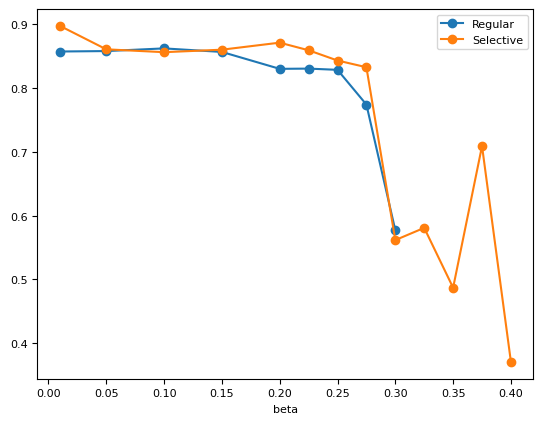

In [101]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='beta').plot(x='beta', y='test_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='beta').plot(x='beta', y='test_acc', ax=ax, label='Selective', marker='o')

<Axes: xlabel='beta'>

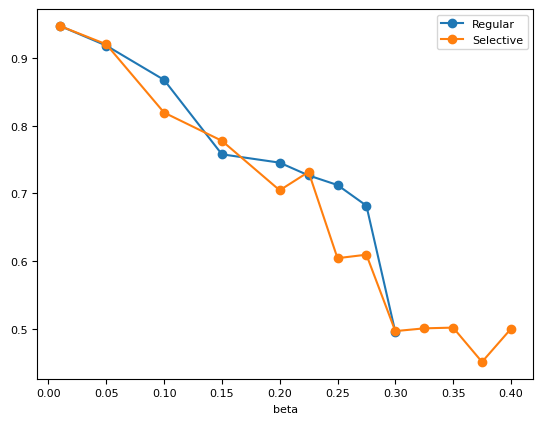

In [102]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='beta').plot(x='beta', y='csmia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='beta').plot(x='beta', y='csmia_acc', ax=ax, label='Selective', marker='o')

Text(0, 0.5, 'CSMIA recall')

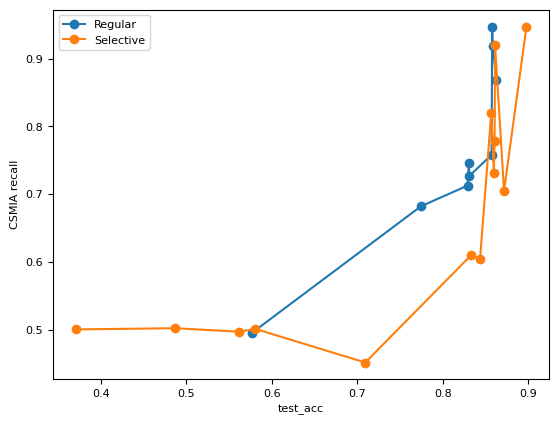

In [99]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='test_acc').plot(x='test_acc', y='csmia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='test_acc').plot(x='test_acc', y='csmia_acc', ax=ax, label='Selective', marker='o')

ax.set_ylabel('CSMIA recall')

Text(0, 0.5, 'LOMIA recall')

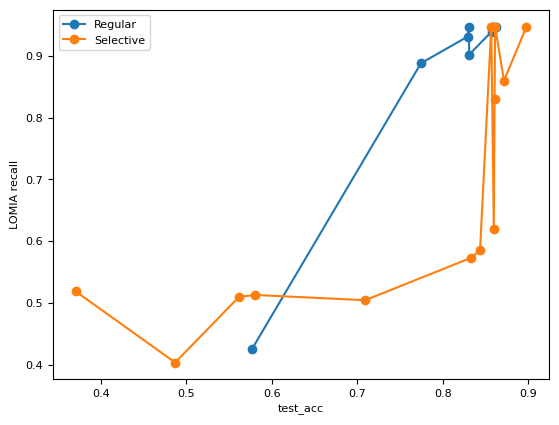

In [100]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='test_acc').plot(x='test_acc', y='lomia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='test_acc').plot(x='test_acc', y='lomia_acc', ax=ax, label='Selective', marker='o')

ax.set_ylabel('LOMIA recall')

Text(0, 0.5, 'CSMIA precision')

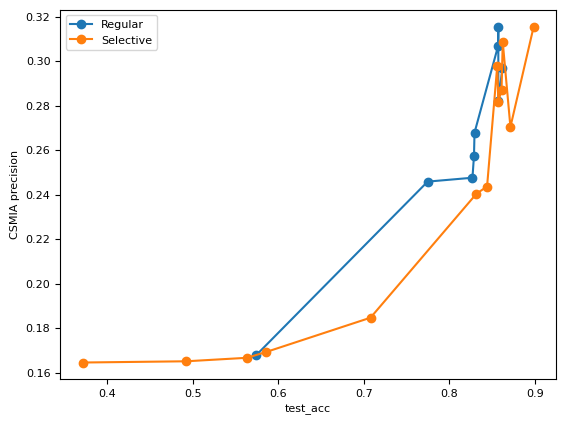

In [94]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='test_acc').plot(x='test_acc', y='csmia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='test_acc').plot(x='test_acc', y='csmia_acc', ax=ax, label='Selective', marker='o')

ax.set_ylabel('CSMIA precision')

Text(0, 0.5, 'LOMIA precision')

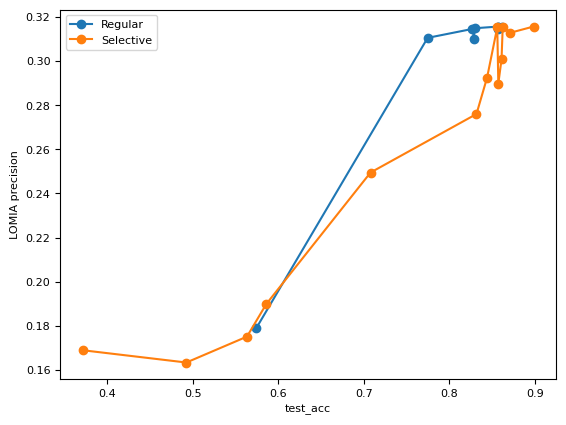

In [95]:
fig, ax = plt.subplots()

# Plot the 'regular' type
perf_df[perf_df['type'] == 'regular'].sort_values(by='test_acc').plot(x='test_acc', y='lomia_acc', ax=ax, label='Regular', marker='o')

# Plot the 'selective' type on the same axis
perf_df[perf_df['type'] == 'selective'].sort_values(by='test_acc').plot(x='test_acc', y='lomia_acc', ax=ax, label='Selective', marker='o')

ax.set_ylabel('LOMIA precision')